In [1]:
import json, glob, yt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from analysis_helpers import *

%matplotlib inline


/home/darksky/anaconda3/lib/python3.8/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/darksky/.config/yt/ytrc is deprecated in favor of /home/darksky/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [2]:
sim = 'phx256-*'
orig_files = glob.glob('/mnt/c/Users/azton/Projects/phoenix_analysis/%s/*p2_origin_qtys.json'%sim)
with open(orig_files[0],'r') as f:
    enr = json.load(f)
for i,ofile in enumerate(orig_files):
    if i == 0: continue
    with open(ofile, 'r') as f:
        data = json.load(f)
    for k in data.keys(): 
        if k != 'distance' and k != 'enricher_mass' and k != 'p3_stats':
            # then append to the current dicts keys
            # print(k)
            enr[k] += data[k]
        elif k == 'p3_stats': # enr['p3_stats'][p3idx][key]
            for kk in data[k].keys(): # for idx in p3idx's
                if kk in enr[k].keys(): # append to preexisting p3idx
                    for j in enr[k][kk].keys():
                       enr[k][kk][j] += data[k][kk][j]
                else: # establish the p3idx
                    enr[k][kk] = data[k][kk]

        else: # then its enr[k][index][qty list]
            # print(k)
            for kk in data[k].keys(): # indexes
                if kk in enr[k].keys(): # then append
                    enr[k][kk] += data[k][kk] 
                else: # then create
                    enr[k][kk] = data[k][kk]

In [3]:
simpaths = ['../phoenix/phx256-%d'%d for d in [1,2]]
fouts = ['RD1250','RD1100']
zbins = np.linspace(-7,3,100)
p2zs = None
for s, fout in zip(simpaths, fouts):
    ds = yt.load('%s/%s/%s'%(s, fout, fout))
    ds = add_particle_filters(ds)
    ad = ds.all_data()
    if p2zs:
        p2zs += [float(z) for z in ad['p2_stars','metallicity_fraction'].to('Zsun')]
    else:
        p2zs = [float(z) for z in ad['p2_stars', 'metallicity_fraction'].to('Zsun')]
        print(ad['p2_stars','metallicity_fraction'].to('Zsun'))





yt : [INFO     ] 2021-07-27 15:44:40,307 Parameters: current_time              = 16.548159927217
yt : [INFO     ] 2021-07-27 15:44:40,308 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2021-07-27 15:44:40,309 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-07-27 15:44:40,310 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-07-27 15:44:40,311 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-07-27 15:44:40,312 Parameters: current_redshift          = 12.451325487595
yt : [INFO     ] 2021-07-27 15:44:40,313 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2021-07-27 15:44:40,313 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2021-07-27 15:44:40,314 Parameters: omega_radiation           = 0
yt : [INFO     ] 2021-07-27 15:44:40,314 Parameters: hubble_constant           = 0.6766
Parsing Hierarchy : 100%|██████████| 27260/27260 [00:03<00:00, 7872.88it/s]
yt : [INFO     ] 2021

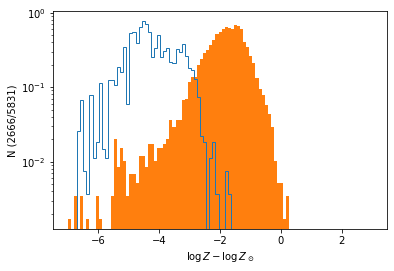

In [7]:
sim = 'phx256-*'
fig, ax = plt.subplots()
ax.hist(np.log10(enr['enrichee_metal']), bins=zbins, density=True, histtype='step', label='PII.1')
ax.hist(np.log10(p2zs), bins=zbins, density=True, histtype='stepfilled', label='PII')
ax.set_yscale('log')
ax.set_xlabel('$\\log Z - \\log Z_\odot$')
ax.set_ylabel('N (%d/%d)'%(len(enr['enrichee_metal']),len(p2zs)))
plt.savefig('p2_origins/%s_p2_MDF.pdf'%sim)


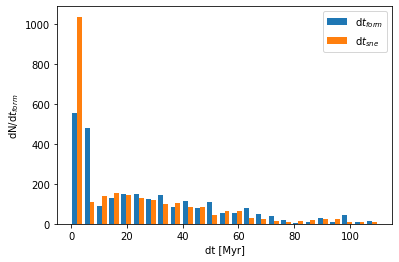

In [163]:
fig, ax = plt.subplots()
ax.hist([enr['formation_dt'], enr['sne_dt']], label=['d$t_{form}$','d$t_{sne}$'], bins=25,range=[0,110])
# ax.hist(enr['sne_dt'], label='d$t_{sne}$', bins=25, color='tab:orange', alpha=0.5, density=True, range=[0,110])
ax.legend()
ax.set_xlabel('dt [Myr]')
ax.set_ylabel('dN/d$t_{form}$')

plt.savefig('p2_origins/%s_dt_toP2.pdf'%sim)


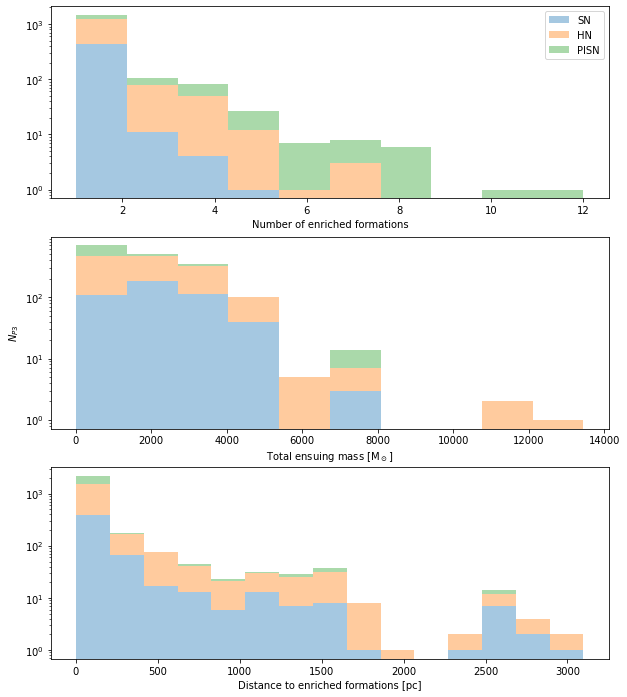

In [164]:

fig, ax = plt.subplots(3,1, figsize=(10,12))
# num_enr = []
# m_enr = []
# r_enr = []

num_sne = [[],[],[]]
m_sne = [[],[],[]]
r_sne = [[],[],[]]

for k in enr['p3_stats'].keys():
    # num_enr += [enr['p3_stats'][k]['n_enriched']]
    # m_enr += [enr['p3_stats'][k]['m_enriched']]
    # r_enr += [enr['p3_stats'][k]['r_enriched']]
    m = enr['p3_stats'][k]['mass']
    if (m > 11) and (m < 20):
        bin = 0
    elif (m >= 20) and (m < 40):
        bin = 1
    elif (m >=140) and (m < 260):
        bin = 2

    num_sne[bin].append(enr['p3_stats'][k]['n_enriched'])
    m_sne[bin].append(enr['p3_stats'][k]['m_enriched'])
    for rad in enr['p3_stats'][k]['r_enriched']:
        r_sne[bin].append(rad)



# ax[0][0].hist(num_enr, bins=10, label='N_{enriched}', density = False)
# ax[1][0].hist(m_enr, bins=10, label='Enriched Mass', density=False)
# ax[2][0].hist(r_enr, bins=15, label='Event distance', density=False)

sne_kind = {0:'SN', 1:'HN', 2:'PISN'}
# for type in [0,1,2]:
ax[0].hist(num_sne, bins=10, label=['SN','HN','PISN'], density=False, alpha=0.4, stacked=True)
ax[1].hist(m_sne, bins=10, density=False, alpha=0.4, stacked=True)
ax[2].hist(r_sne, bins=15, density=False, alpha=0.4, stacked=True)
ax[0].legend()
ax[0].set_xlabel('Number of enriched formations')
ax[1].set_xlabel('Total ensuing mass [M$_\odot$]')
ax[2].set_xlabel('Distance to enriched formations [pc]')
ax[2].set_yscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel('$N_{P3}$')

plt.savefig('p2_origins/%s_SNeffect.pdf'%sim)




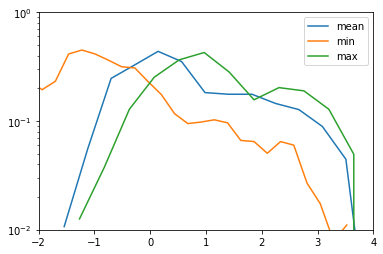

In [165]:
fig, ax = plt.subplots()
for k in ['enricher_mean_z','enricher_min_z','enricher_max_z']:
    hist, bins = np.histogram(np.log10(enr[k]), bins=25, density=True)
    ax.plot(bins[1:], hist, label=k.split('_')[1])
ax.set_yscale('log')
ax.set_xlim(-2, 4)
ax.set_ylim(1e-2, 1)
ax.legend()
plt.savefig('p2_origins/%s_zpathstat.pdf'%sim)


In [13]:
# plot sne, hne, pisn only enrichment
# sne-hne, sne-pisn, sne-hne, hne-pisn, sne-hne-pisn
labels = ['SN','HN','PISN','SN-HN','SN-PISN','HN-PISN','SN-HN-PISN']
counts = [0, 0, 0, 0, 0, 0, 0]
radii = [[] for c in counts]
nenrichers = [[] for c in counts]
r_enrichers = [[] for c in counts]
p2metals = [[] for c in counts]
mass_enr = [[] for c in counts]
enrichers = []
n_formed = 0
for i, id in enumerate(enr['enricher_mass'].keys()):
    this_enr = [0,0,0]
    n_formed += 1
    mt = 0
    for m in enr['enricher_mass'][id]:
        # print('%0.2f'%m, end=' ')
        if m > 11 and m <= 20:
            this_enr[0] += 1
            mt += m
        elif m > 20 and m < 40.0059:
            this_enr[1] += 1
            mt += m
        elif m >140 and m < 260:
            this_enr[2] += 1
            mt += m
        else:
            print('%e mass out of bounds, whats that all about?'%(m/1e20))
    if this_enr[0] > 0 and this_enr[1] == 0:
        print(this_enr)
    # if this_enr[2] > 1 and this_enr[0]==0 and this_enr[1] == 0:
    #     print('MultiPISN!')
    binid = [1 if i > 0 else 0 for i in this_enr]
    this_enr = binid
    # print('\n\n')
    if this_enr == [1,0,0]: # SNE
        mass_enr[0] .append(mt)
        counts[0] += 1
        radii[0] += enr['distance'][id]
        nenrichers[0].append(len(enr['distance'][id]))
        r_enrichers[0].append(np.average(enr['distance'][id]))
        p2metals[0].append(enr['enrichee_metal'][i])
    elif this_enr == [0,1,0]: # HNE
        mass_enr[1] .append(mt)
        counts[1] += 1
        radii[1] += enr['distance'][id]
        r_enrichers[1].append(np.average(enr['distance'][id]))
        p2metals[1].append(enr['enrichee_metal'][i])
        nenrichers[1].append(len(enr['distance'][id]))
    elif this_enr == [0,0,1]: # PISN
        mass_enr[2] .append(mt)
        counts[2] += 1
        radii[2] += enr['distance'][id]
        nenrichers[2].append(len(enr['distance'][id]))
        r_enrichers[2].append(np.average(enr['distance'][id]))
        p2metals[2].append(enr['enrichee_metal'][i])
    elif this_enr == [1,1,0]: # SN+HN
        mass_enr[3] .append(mt)
        counts[3] += 1
        radii[3] += enr['distance'][id]
        nenrichers[3].append(len(enr['distance'][id]))
        r_enrichers[3].append(np.average(enr['distance'][id]))
        p2metals[3].append(enr['enrichee_metal'][i])
    elif this_enr == [1,0,1]: # SN + PISN
        mass_enr[4].append(mt)
        counts[4] += 1
        radii[4] += enr['distance'][id]
        nenrichers[4].append(len(enr['distance'][id]))
        r_enrichers[4].append(np.average(enr['distance'][id]))
        p2metals[4].append(enr['enrichee_metal'][i])
    elif this_enr == [0, 1, 1]: # HN + PISN
        mass_enr[5] .append(mt)
        counts[5] += 1
        radii[5] += enr['distance'][id]
        nenrichers[5].append(len(enr['distance'][id]))
        r_enrichers[5].append(np.average(enr['distance'][id]))
        p2metals[5].append(enr['enrichee_metal'][i])
    elif this_enr == [1,1,1]: # ALL
        mass_enr[6] .append(mt)
        counts[6] += 1
        radii[6] += enr['distance'][id]
        nenrichers[6].append(len(enr['distance'][id]))
        r_enrichers[6].append(np.average(enr['distance'][id]))
        p2metals[6].append(enr['enrichee_metal'][i])


[8, 0, 0]
[1, 0, 0]
1.050182e-01 mass out of bounds, whats that all about?
6.987114e-02 mass out of bounds, whats that all about?
7.509548e-02 mass out of bounds, whats that all about?
7.340177e-02 mass out of bounds, whats that all about?
6.987114e-02 mass out of bounds, whats that all about?
7.509548e-02 mass out of bounds, whats that all about?
7.340177e-02 mass out of bounds, whats that all about?
6.987114e-02 mass out of bounds, whats that all about?
7.509548e-02 mass out of bounds, whats that all about?
7.340177e-02 mass out of bounds, whats that all about?
6.987114e-02 mass out of bounds, whats that all about?
7.509548e-02 mass out of bounds, whats that all about?
7.340177e-02 mass out of bounds, whats that all about?
6.987114e-02 mass out of bounds, whats that all about?
7.509548e-02 mass out of bounds, whats that all about?
7.340177e-02 mass out of bounds, whats that all about?
6.987114e-02 mass out of bounds, whats that all about?
7.509548e-02 mass out of bounds, whats that a

<ipython-input-16-a8c98c3d5d33>:78: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axt.set_ylim(0,0.8)
[8.48500739e-07 8.48500739e-07 3.16694527e-07 3.55938861e-06
 5.27265493e-06 3.88786191e-06 5.49218029e-07] [1.04398516e-03 1.98507401e-03 2.23330524e-02 1.59555653e-02
 5.27265493e-06 1.47967920e-03 1.98507401e-03]
[ 35.58598147  73.24589685 226.46633487 201.06345921 201.42012106
 299.20753631 584.54262422]


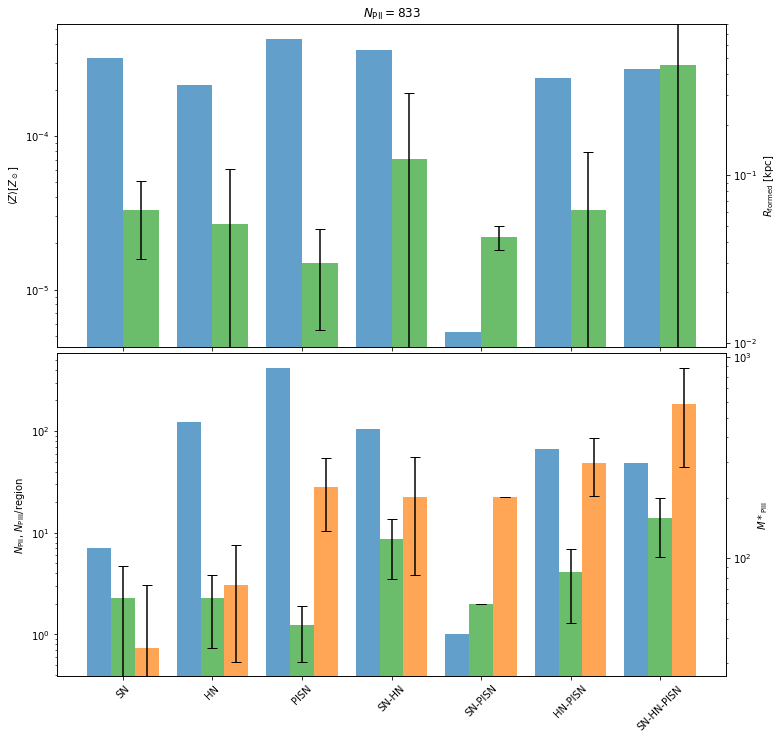

In [16]:
# print(counts)
means = np.array([np.average(r) if len(r) > 0 else 0 for r in radii])
minr = np.array([min(r) if len(r) > 0 else 0 for r in radii])
maxr = np.array([max(r) if len(r) > 0 else 0 for r in radii])
stdr = np.array([np.std(r) if len(r) > 0 else 0 for r in radii])

mean_n = [np.average(n) if len(n) > 0 else 0 for n in nenrichers]
std_n = [np.std(n) if len(n) > 0 else 0 for n in nenrichers]

mean_z = np.array([np.average(z) if len(z) > 0 else 0 for z in p2metals])
max_z = np.array([max(z) if len(z) > 0 else 0 for z in p2metals])
min_z = np.array([min(z) if len(z) > 0 else 0 for z in p2metals])

mform = np.array([np.average(m) if len(m) > 0 else 0 for m in mass_enr])
mmax = np.array([max(m) if len(m) > 0 else 0 for m in mass_enr])
mmin = np.array([min(m) if len(m) > 0 else 0 for m in mass_enr])
mstd = np.array([np.std(m) if len(m) > 0 else 0 for m in mass_enr])

fig, ax = plt.subplots(2,1, figsize=(12,12), sharex=True)
axt = ax[0].twinx()
ax[0].set_title('$N_{\\rm PII} = $%d'%n_formed)

label_loc = np.arange(len(labels))
width=0.8/2.0
ax[0].bar(label_loc, mean_z,
                tick_label=labels,
                alpha=0.7,
                width=-1*width,
                # yerr=[max_z, min_z],
                # capsize=5,
                align='edge',
                color='tab:blue',
                label='$Z_{\\rm P2}[Z_\odot}$')
axt.bar(label_loc, means/1e3, 
                yerr=stdr/1e3, 
                tick_label=labels, 
                alpha=0.7, 
                color='tab:green',
                capsize=5,
                width=width,
                align='edge', 
                label = '$\langle N_{\\rm P3}/{\\rm region} \\rangle$')

width = 0.8/3.
ax[1].bar(label_loc-width, np.array(counts), 
                tick_label=labels, 
                alpha = 0.7, 
                width=width, 
                align='center', 
                color='tab:blue',
                label = '$N_{\\rm P2}$')
axt1 = ax[1].twinx()
axt1.bar(label_loc+width, mform,
                tick_label=labels,
                alpha=0.7,
                width=width,
                yerr = mstd,
                capsize=5,
                align='center',
                color='tab:orange',
                label='$M_{\\rm PIII}$')
ax[1].bar(label_loc, mean_n, 
                tick_label=labels, 
                alpha=0.7, 
                width=width, 
                align='center', 
                color='tab:green',
                capsize=5,
                yerr=std_n,
                label='$R_{\\rm enrich}$')

ax[0].set_yscale('log')
ax[0].set_ylabel('$\\langle Z\\rangle [Z_\odot]$')
# ax[0].set_ylim(7e-5, 1e-3)
axt.set_yscale('log')
axt1.set_yscale('log')
ax[1].set_yscale('log')
axt.set_ylim(0,0.8)
# ax.set_ylim(0, 40)
axt.set_ylabel('$R_{\\rm formed}$ [kpc]')
ax[1].set_ylabel('$N_{\\rm PII}$, $N_{\\rm PIII}/$region')
axt1.set_ylabel('$M*_{\\rm PIII}$')
ax[1].set_xticklabels(labels, rotation=45)
plt.subplots_adjust(hspace=0.02)
plt.savefig('Formation_stats.pdf')
print(min_z, max_z)
print(mform)


<ipython-input-168-d548b7a6b677>:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im.append(ax[i].hist2d(r_enrichers[i], p2metals[i], bins=[xbins,ybins], cmap = 'winter', norm=LogNorm(), label=l, alpha=0.9, vmin=1, vmax=35))
<ipython-input-168-d548b7a6b677>:15: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im.append(ax[-1].hist2d(allrz[0], allrz[1], bins=[xbins,ybins], label=l, alpha=0.8, cmap='winter', norm=LogNorm(),vmin=1, vmax=35))


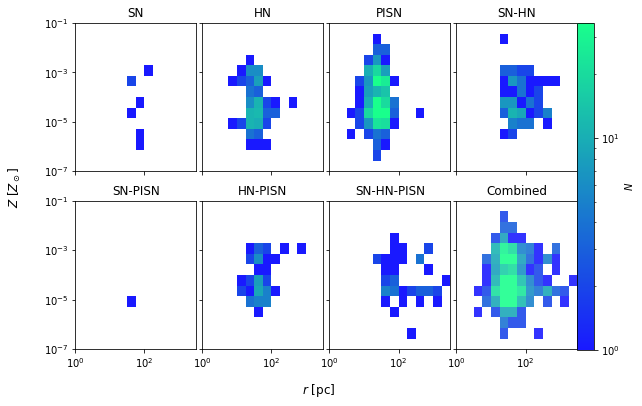

In [168]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(2,4, figsize=(9,6), sharex=True, sharey=True)
ax= ax.flatten()
ybins = np.logspace(-7,-1, 15)
xbins = np.logspace(0, 3.5, 15)
allrz = [[],[]]
im = []
for i, l in enumerate(labels):
    allrz[0]+=r_enrichers[i]
    allrz[1]+=p2metals[i]
    im.append(ax[i].hist2d(r_enrichers[i], p2metals[i], bins=[xbins,ybins], cmap = 'winter', norm=LogNorm(), label=l, alpha=0.9, vmin=1, vmax=35))
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_title(l)
im.append(ax[-1].hist2d(allrz[0], allrz[1], bins=[xbins,ybins], label=l, alpha=0.8, cmap='winter', norm=LogNorm(),vmin=1, vmax=35))
ax[-1].set_yscale('log')
ax[-1].set_xscale('log')
ax[-1].set_title("Combined")
fig.supxlabel('$r$ [pc]')
fig.supylabel('$Z$ $[Z_\odot]$')
cax = fig.add_axes([0.9, 0.124, 0.025, 0.756])
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(wspace=0.05)
cb = fig.colorbar(im[2][3], cax=cax, label = '$N$')
plt.savefig('./images/sntype_rVz_2dhist.pdf', bbox_inches='tight')

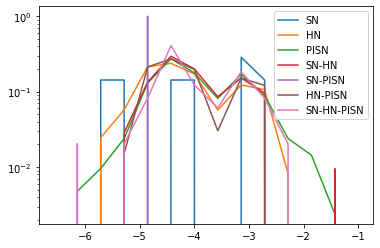

In [178]:
fig, ax = plt.subplots()
zbins = np.linspace(-7,-1,15)
sum = 0
for z in p2metals:
    sum += len(z)
for z, l in zip(p2metals, labels):
    hist, bins = np.histogram(np.log10(z), bins=zbins)
    ax.plot(zbins[1:], hist/len(z), label=l)
ax.set_yscale('log')
ax.legend()

/home/darksky/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/darksky/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


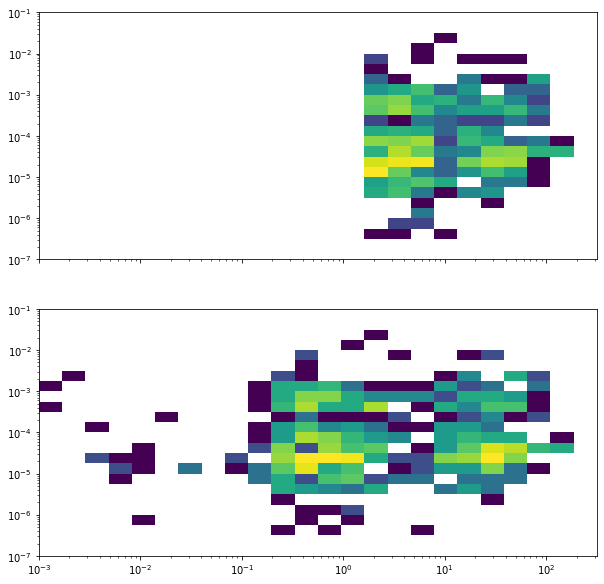

In [154]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True, sharey=True)
mean_r = []
mean_dtsn = []
mean_dtform = []
mean_z = []
i0 = 0
for i, pid in enumerate(enr['enricher_mass'].keys()):
    n3 = len(enr['distance'][pid])
    mean_r += [
                np.average(enr['distance'][pid])
    ]
    mean_dtform += [
                np.average(enr['formation_dt'][i0:i0+n3])
    ]
    mean_dtsn += [
                np.average(enr['sne_dt'][i0:i0+n3])
    ]
    i0 += n3
    mean_z.append(enr['enrichee_metal'][i])
# print(mean_dtsn)
xbins = np.logspace(-3,2.5,25)
ybins = np.logspace(-7,-1,25)
ax[0].hist2d(mean_dtform, mean_z, bins=[xbins, ybins], norm=LogNorm())
ax[1].hist2d(mean_dtsn, mean_z, bins=[xbins,ybins], norm=LogNorm())
ax[0].set_yscale('log')
ax[1].set_xscale('log')


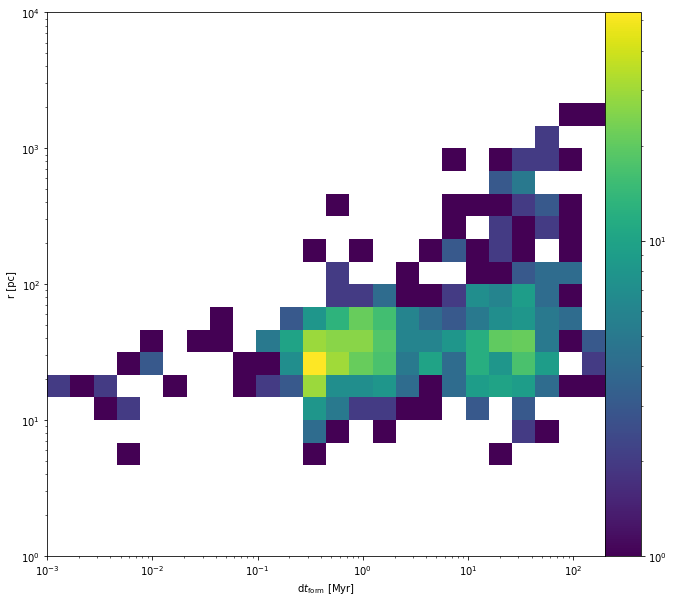

In [155]:
fig, ax = plt.subplots(figsize=(10,10), sharex=True, sharey=True)
rbins= np.logspace(0,4,25)
xbins = np.logspace(-3,2.3,25)

im = ax.hist2d(mean_dtsn, mean_r, bins=[xbins, rbins], norm=LogNorm())
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('d$t_{\\rm form}$ [Myr]')
ax.set_ylabel('r [pc]')
plt.subplots_adjust(right=0.9)
cax = fig.add_axes([0.9,0.125, 0.05, 0.7552])
fig.colorbar(im[3], cax)